<a href="https://colab.research.google.com/github/HazemmoAlsady/AWN_Graduation_Project/blob/main/Hazem's%20edits/Preprocessing_%26_need_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Features & Target**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import joblib

df = pd.read_excel('/content/drive/MyDrive/cleaned_awn_data.xlsx')


In [3]:
df = df[df["need_level"] != "Unknown"]


In [4]:
from sklearn.model_selection import train_test_split

target = "need_level"

features = [
    "family_size",
    "income_monthly",
    "monthly_expenses",
    "debts",
    "number_of_children",
    "age",
    "expense_to_income_ratio",
    "case_type",
    "housing_type",
    "health_status",
    "city",
    "gender"
]

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# **Encdoing**

In [5]:
from sklearn.preprocessing import LabelEncoder

cat_cols = X.select_dtypes(include="object").columns

label_encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le


In [6]:
target_encoder = LabelEncoder()

y_train = target_encoder.fit_transform(y_train)
y_test = target_encoder.transform(y_test)

print("Target mapping:")
print(dict(zip(
    target_encoder.classes_,
    target_encoder.transform(target_encoder.classes_)
)))


Target mapping:
{'High': np.int64(0), 'Low': np.int64(1), 'Medium': np.int64(2)}


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

log_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

log_pipeline.fit(X_train, y_train)

y_pred_log = log_pipeline.predict(X_test)

print("Logistic Regression Accuracy:",
      accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


Logistic Regression Accuracy: 0.8840256211180124
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2821
           1       0.80      0.92      0.86      2014
           2       0.94      0.84      0.89      5469

    accuracy                           0.88     10304
   macro avg       0.87      0.90      0.88     10304
weighted avg       0.89      0.88      0.88     10304



In [8]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        min_samples_split=10,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)

print("Random Forest Accuracy:",
      accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.9420613354037267
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2821
           1       0.91      0.95      0.93      2014
           2       0.95      0.95      0.95      5469

    accuracy                           0.94     10304
   macro avg       0.94      0.94      0.94     10304
weighted avg       0.94      0.94      0.94     10304



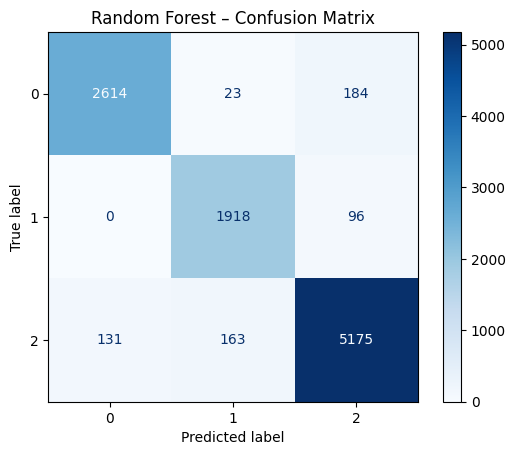

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    rf_pipeline,
    X_test,
    y_test,
    cmap="Blues"
)

plt.title("Random Forest – Confusion Matrix")
plt.show()


In [10]:
import pandas as pd

rf_model = rf_pipeline.named_steps["model"]

feature_importance = pd.DataFrame({
    "feature": features,
    "importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)

feature_importance


,feature,importance
3,debts,0.411022
2,monthly_expenses,0.254210
6,expense_to_income_ratio,0.214878
1,income_monthly,0.077830
5,age,0.010834
4,number_of_children,0.005566
9,health_status,0.005334
0,family_size,0.005160
8,housing_type,0.004904
7,case_type,0.004808


In [11]:
!pip install xgboost


In [12]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
xgb_model = XGBClassifier(
    objective="multi:softprob",   # multi-class
    num_class=3,                  # Low / Medium / High
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)


In [13]:
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1, num_class=3, ...)

In [14]:
y_pred_xgb = xgb_model.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report

print("XGBoost Accuracy:",
      accuracy_score(y_test, y_pred_xgb))

print(classification_report(y_test, y_pred_xgb))


XGBoost Accuracy: 0.9469138198757764
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      2821
           1       0.93      0.94      0.93      2014
           2       0.94      0.96      0.95      5469

    accuracy                           0.95     10304
   macro avg       0.95      0.94      0.94     10304
weighted avg       0.95      0.95      0.95     10304



In [15]:
# Prediction على Test Set
y_pred_log_test = log_pipeline.predict(X_test)

# Accuracy
log_acc = accuracy_score(y_test, y_pred_log_test)
print("Logistic Regression Test Accuracy:", log_acc)

# Classification Report
print("\nLogistic Regression – Classification Report")
print(classification_report(y_test, y_pred_log_test))


Logistic Regression Test Accuracy: 0.8840256211180124

Logistic Regression – Classification Report
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      2821
           1       0.80      0.92      0.86      2014
           2       0.94      0.84      0.89      5469

    accuracy                           0.88     10304
   macro avg       0.87      0.90      0.88     10304
weighted avg       0.89      0.88      0.88     10304



In [16]:
# Prediction على Test Set
y_pred_rf_test = rf_pipeline.predict(X_test)

# Accuracy
rf_acc = accuracy_score(y_test, y_pred_rf_test)
print("Random Forest Test Accuracy:", rf_acc)

# Classification Report
print("\nRandom Forest – Classification Report")
print(classification_report(y_test, y_pred_rf_test))


Random Forest Test Accuracy: 0.9420613354037267

Random Forest – Classification Report
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2821
           1       0.91      0.95      0.93      2014
           2       0.95      0.95      0.95      5469

    accuracy                           0.94     10304
   macro avg       0.94      0.94      0.94     10304
weighted avg       0.94      0.94      0.94     10304



In [17]:
# Prediction على Test Set
y_pred_rf_test = rf_pipeline.predict(X_test)

# Accuracy
rf_acc = accuracy_score(y_test, y_pred_rf_test)
print("Random Forest Test Accuracy:", rf_acc)

# Classification Report
print("\nRandom Forest – Classification Report")
print(classification_report(y_test, y_pred_rf_test))


Random Forest Test Accuracy: 0.9420613354037267

Random Forest – Classification Report
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      2821
           1       0.91      0.95      0.93      2014
           2       0.95      0.95      0.95      5469

    accuracy                           0.94     10304
   macro avg       0.94      0.94      0.94     10304
weighted avg       0.94      0.94      0.94     10304



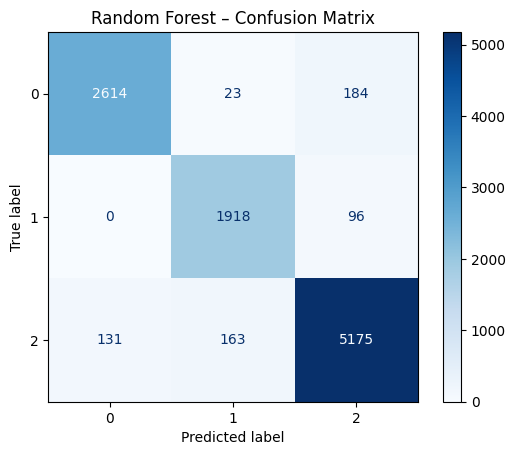

In [18]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_rf_test,
    cmap="Blues"
)
plt.title("Random Forest – Confusion Matrix")
plt.show()


In [19]:
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Test Accuracy": [log_acc, rf_acc]
})

comparison


,Model,Test Accuracy
0,Logistic Regression,0.884026
1,Random Forest,0.942061


# **Assistance Type Classification**

In [20]:
df2 = df.copy()

# نشيل Unknown
df2 = df2[
    (df2["assistance_type"] != "Unknown") &
    (df2["request_text"] != "Unknown")
].reset_index(drop=True)


In [21]:
import re

def clean_request_text(text):
    text = str(text)

    leakage_words = [
        "سلة غذائية", "غذائية", "طعام",
        "علاج", "أدوية", "عملية",
        "مصاريف مدارس", "مدارس", "تعليم",
        "كرسي متحرك", "إعاقة", "ذوي إعاقة",
        "مساعدة مالية", "مالية",
        "سكن", "إيجار"
    ]

    for word in leakage_words:
        text = re.sub(word, "", text)

    # إزالة تكرار المسافات
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [22]:
df2["request_text_clean"] = df2["request_text"].apply(clean_request_text)


In [23]:
text_feature = "request_text_clean"

num_features = [
    "family_size",
    "income_monthly",
    "monthly_expenses",
    "debts",
    "number_of_children",
    "age",
    "expense_to_income_ratio"
]

cat_features = [
    "case_type",
    "housing_type",
    "health_status",
    "city",
    "gender"
]

X = df2[num_features + cat_features + [text_feature]]
y = df2["assistance_type"]


In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


In [26]:
preprocessor = ColumnTransformer(
    transformers=[
        # NLP
        ("text", TfidfVectorizer(
            max_features=6000,
            ngram_range=(1,2)
        ), text_feature),

        # Categorical
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features),

        # Numerical
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median"))
        ]), num_features)
    ]
)


In [27]:
from sklearn.preprocessing import LabelEncoder

target_encoder = LabelEncoder()
y_train_enc = target_encoder.fit_transform(y_train)
y_test_enc = target_encoder.transform(y_test)

print("Classes:", target_encoder.classes_)


Classes: ['disability_equipment' 'education' 'financial' 'food' 'housing' 'medical']


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


In [29]:
rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=22,
        min_samples_split=10,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])


In [30]:
rf_pipeline.fit(X_train, y_train_enc)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(max_features=6000,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'request_text_clean'),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['case_type', 'housing_type',
                                                   'health_status', 'city',
                                                   'gender']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['family_size',
                                                   'income_monthly',
                                                   'monthly_expenses', 'debts',
                                                   'number_of_children', 'age',
                                                   'expense_to_income_ratio'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=22,
                                        min_samples_split=10, n_estimators=300,
                                        n_jobs=-1, random_state=42))])

In [31]:
y_pred = rf_pipeline.predict(X_test)

print("Assistance Type Accuracy (Clean Text):",
      accuracy_score(y_test_enc, y_pred))

print(classification_report(
    y_test_enc,
    y_pred,
    target_names=target_encoder.classes_
))


Assistance Type Accuracy (Clean Text): 1.0
                      precision    recall  f1-score   support

disability_equipment       1.00      1.00      1.00       615
           education       1.00      1.00      1.00      1261
           financial       1.00      1.00      1.00      1835
                food       1.00      1.00      1.00      1865
             housing       1.00      1.00      1.00      1228
             medical       1.00      1.00      1.00      2500

            accuracy                           1.00      9304
           macro avg       1.00      1.00      1.00      9304
        weighted avg       1.00      1.00      1.00      9304



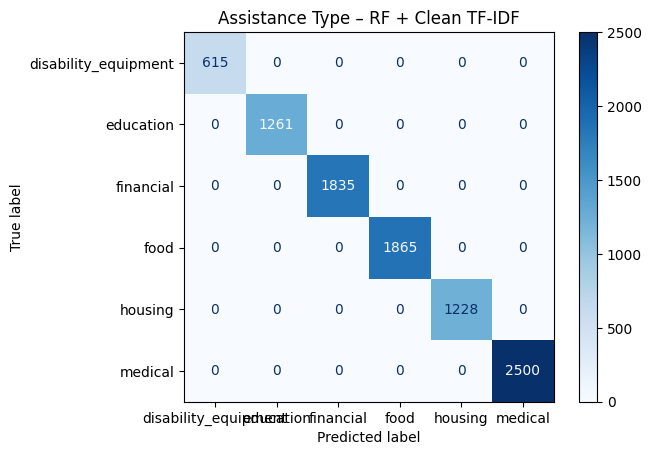

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(
    y_test_enc,
    y_pred,
    display_labels=target_encoder.classes_,
    cmap="Blues"
)

plt.title("Assistance Type – RF + Clean TF-IDF")
plt.show()


In [33]:
import os

BASE_PATH = "/content/drive/MyDrive/graduation_project"
os.makedirs(BASE_PATH, exist_ok=True)


In [34]:
import joblib

# Save Need Level Model Pipeline
joblib.dump(
    rf_pipeline,
    f"{BASE_PATH}/need_level_rf_pipeline.joblib"
)

# Save Target Encoder
joblib.dump(
    target_encoder,
    f"{BASE_PATH}/need_level_target_encoder.joblib"
)


['/content/drive/MyDrive/graduation_project/need_level_target_encoder.joblib']

In [35]:
joblib.dump(
    rf_pipeline,
    f"{BASE_PATH}/assistance_type_rf_pipeline.joblib"
)

joblib.dump(
    target_encoder,
    f"{BASE_PATH}/assistance_type_target_encoder.joblib"
)


['/content/drive/MyDrive/graduation_project/assistance_type_target_encoder.joblib']

In [36]:
import pickle
import os

BASE_PATH = "/content/drive/MyDrive/graduation_project"
os.makedirs(BASE_PATH, exist_ok=True)

# Save Need Level Pipeline
with open(f"{BASE_PATH}/need_level_rf_pipeline.pkl", "wb") as f:
    pickle.dump(rf_pipeline, f)

# Save Target Encoder
with open(f"{BASE_PATH}/need_level_target_encoder.pkl", "wb") as f:
    pickle.dump(target_encoder, f)


In [37]:
# Save Assistance Type Pipeline
with open(f"{BASE_PATH}/assistance_type_rf_pipeline.pkl", "wb") as f:
    pickle.dump(rf_pipeline, f)

# Save Assistance Type Target Encoder
with open(f"{BASE_PATH}/assistance_type_target_encoder.pkl", "wb") as f:
    pickle.dump(target_encoder, f)
